In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_california_housing
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lime.lime_tabular import LimeTabularExplainer
import shap
from anchor import anchor_tabular
from sklearn.inspection import permutation_importance
from PyALE import ale
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score


c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\InterpretableAI_ARI3205\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
housing = fetch_california_housing()

X = housing.data
y = housing.target

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFeature names:")
print(housing.feature_names)

Features (X) shape: (20640, 8)
Target (y) shape: (20640,)

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


# Part 1: Feature-Level Interpretability (30 marks)  
You will use the California Housing and the Adult Census Income datasets in this part. You 
should train one feed-forward neural network for each dataset and apply the following 
interpretability techniques:

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier

# 1. Load data
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
train_adult = pd.read_csv(
    "DataSets/census/adult.data", header=None, names=columns, sep=",",
    na_values=" ?", skipinitialspace=True
)
test_adult = pd.read_csv(
    "DataSets/census/adult.test", header=0, names=columns, sep=",",
    na_values=" ?", skipinitialspace=True, comment="|"
)
test_adult["income"] = test_adult["income"].str.replace(".", "", regex=False)

# 2. Concatenate, clean, and split
data_adult = pd.concat([train_adult, test_adult], ignore_index=True).dropna()
X_adult = data_adult.drop("income", axis=1)
y_adult = (data_adult["income"] == ">50K").astype(int)

# 3. Identify column types
cat_cols = X_adult.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_adult.select_dtypes(exclude=["object"]).columns.tolist()

# 4. Train/test split (split before transformation to prevent info leakage)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_adult, y_adult, test_size=0.2, random_state=42
)

# 5. ColumnTransformer: OneHot for cats, Scale for nums
ct = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("scale", StandardScaler(), num_cols)
])

# 6. Fit on train, transform both sets, and force dense ndarray
ect = ct.fit(X_train_raw)
X_train_adult = ct.transform(X_train_raw)
X_test_adult = ct.transform(X_test_raw)

# 7. Check shape and output feature names
output_feature_names = ct.get_feature_names_out()
print(f"Processed train shape: {X_train_adult.shape}")
print(f"Feature count: {len(output_feature_names)}")

for idx, name in enumerate(output_feature_names):
    print(f"{idx}: {name}")

# 8. Define and wrap the Keras model

def create_model():
    model = keras.Sequential([
        layers.Input(shape=(X_train_adult.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

model_adult = KerasClassifier(model=create_model, epochs=10, batch_size=256, verbose=1)

# 9. Train the model
history = model_adult.fit(X_train_adult, y_train_raw, validation_split=0.2)

# 10. Evaluate on test set
print("--- Training Complete ---")
test_loss, test_acc = model_adult.model_.evaluate(X_test_adult, y_test_raw, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Processed train shape: (39072, 108)
Feature count: 108
0: onehot__workclass_?
1: onehot__workclass_Federal-gov
2: onehot__workclass_Local-gov
3: onehot__workclass_Never-worked
4: onehot__workclass_Private
5: onehot__workclass_Self-emp-inc
6: onehot__workclass_Self-emp-not-inc
7: onehot__workclass_State-gov
8: onehot__workclass_Without-pay
9: onehot__education_10th
10: onehot__education_11th
11: onehot__education_12th
12: onehot__education_1st-4th
13: onehot__education_5th-6th
14: onehot__education_7th-8th
15: onehot__education_9th
16: onehot__education_Assoc-acdm
17: onehot__education_Assoc-voc
18: onehot__education_Bachelors
19: onehot__education_Doctorate
20: onehot__education_HS-grad
21: onehot__education_Masters
22: onehot__education_Preschool
23: onehot__education_Prof-school
24: onehot__education_Some-college
25: onehot__marital-status_Divorced
26: onehot__marital-status_Married-AF-spouse
27: onehot__marital-status_Married-civ-spouse
28: onehot__marital-status_Married-spouse-abse

In [ ]:
# California Housing Dataset pre-processing and neural network model

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"Total data points: {len(X)}")
print(f"Training data points: {len(X_train)}")
print(f"Validation data points: {len(X_valid)}")
print(f"Test data points: {len(X_test)}")


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("Data successfully scaled")
print(f"Original mean (first feature): {X_train[:, 0].mean():.4f}")
print(f"Scaled mean (first feature): {X_train_scaled[:, 0].mean():.4f}")


def create_model():

    n_features = X_train_scaled.shape[1]

    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[X_train_scaled.shape[1]]),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ])
    
    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["mean_absolute_error"]
    )
    
    return model

model = KerasRegressor(
    model=create_model,
    verbose=0
)

print("Keras Wrapper created successfully")

print("Model compiled with MSE as the loss function and Dropout Layers and a custom Adam.")

print("--- Starting Model Training ---")

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

print("--- Model Training Finished ---")

print("--- Evaluating Model on Test Set ---")

y_pred = model.predict(X_test_scaled)

final_mse = mean_squared_error(y_test, y_pred)
final_mae = mean_absolute_error(y_test, y_pred)

print(f"Final Test Set MSE (Mean Squared Error): {final_mse:.4f}")
print(f"Final Test Set MAE (Mean Absolute Error): {final_mae:.4f}")

Total data points: 20640
Training data points: 13209
Validation data points: 3303
Test data points: 4128
Data successfully scaled
Original mean (first feature): 3.8689
Scaled mean (first feature): -0.0000
Keras Wrapper created successfully
Model compiled with MSE as the loss function and Dropout Layers and a custom Adam.
--- Starting Model Training ---


c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\interpretableaiproject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1018 - mean_absolute_error: 0.7307 - val_loss: 0.5403 - val_mean_absolute_error: 0.5055
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5791 - mean_absolute_error: 0.5408 - val_loss: 0.4281 - val_mean_absolute_error: 0.4695
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4980 - mean_absolute_error: 0.5061 - val_loss: 0.4083 - val_mean_absolute_error: 0.4563
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4522 - mean_absolute_error: 0.4810 - val_loss: 0.3961 - val_mean_absolute_error: 0.4524
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4253 - mean_absolute_error: 0.4660 - val_loss: 0.3847 - val_mean_absolute_error: 0.4408
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4084 - mean_absolute_error: 0.4544 - val_loss: 0.3779 - val_mean_absolute_error: 0.4396
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3967 - mean_absolute_error: 0.4

## 1. Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots (7 marks) 
### a. Use PDP to examine the average effect of at least two features. 

Found 108 processed features.

Calculating and plotting for 'scale__age'...
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━

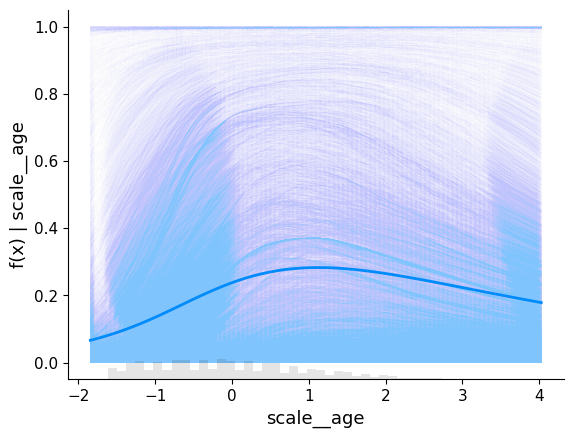


Calculating and plotting for 'scale__hours-per-week'...
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/st

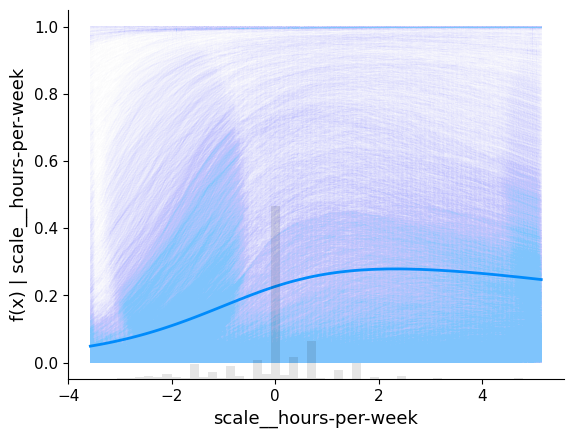

In [ ]:
actual_keras_model = model.model_

full_feature_names = ct.get_feature_names_out()
print(f"Found {len(full_feature_names)} processed features.")

X_train_df = pd.DataFrame(X_train_adult.toarray(), columns=full_feature_names)

predict_fn = lambda X: actual_keras_model.predict(X).ravel()

features_to_plot = ["scale__age", "scale__hours-per-week"]

for feature in features_to_plot:
    print(f"\nCalculating and plotting for '{feature}'...")
    shap.plots.partial_dependence(
        feature,
        predict_fn,
        X_train_df,
        show=True
    )


Calculating and plotting PDP for 'MedInc'...
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

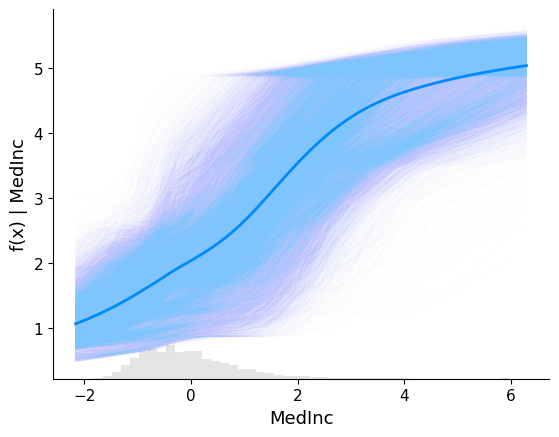


Calculating and plotting PDP for 'HouseAge'...
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1

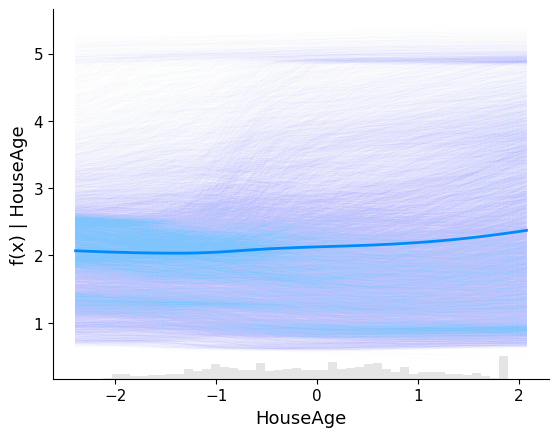

In [ ]:
# California Housing

actual_keras_model = model.model_

original_feature_names = housing.feature_names

predict_fn = lambda X: actual_keras_model.predict(X).ravel()

print("\nCalculating and plotting PDP for 'MedInc'...")
shap.plots.partial_dependence(
    "MedInc",
    predict_fn,
    X_train_scaled,
    feature_names=original_feature_names,
    show=True
)

print("\nCalculating and plotting PDP for 'HouseAge'...")
shap.plots.partial_dependence(
    "HouseAge",
    predict_fn,
    X_train_scaled,
    feature_names=original_feature_names,
    show=True
)

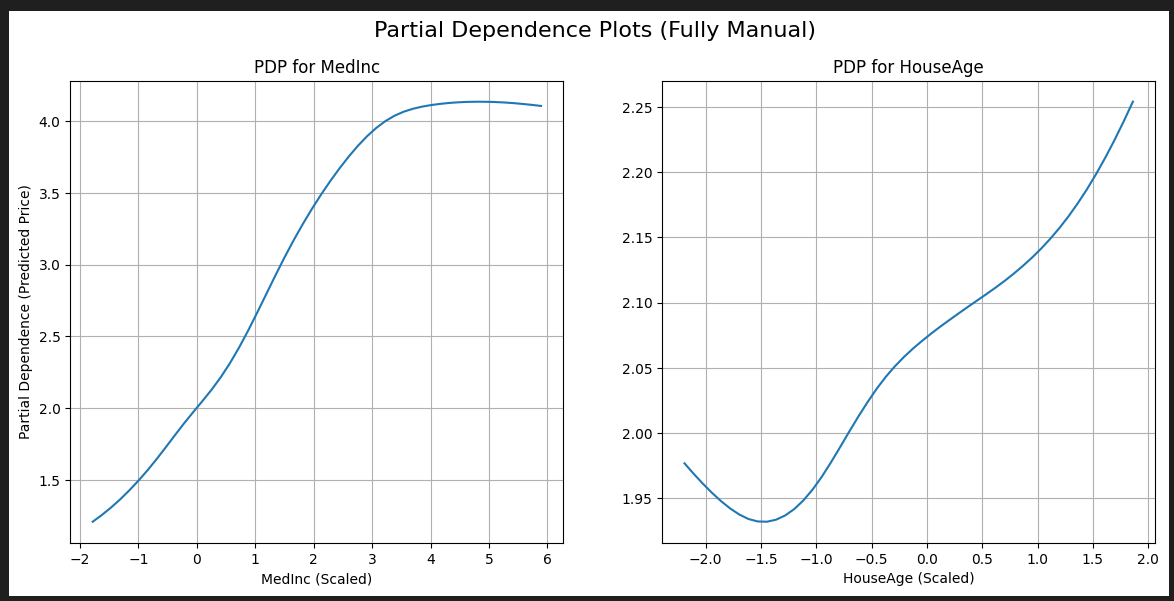

### b. Use ICE plots to explore individual predictions for at least two features. 

In [ ]:
#ICE and PDP for Adult Census Income Dataset are implemented together in the previous Task.

In [ ]:
#ICE and PDP for California Housing are implemented together in the previous Task

### c. Explain what insights PDP and ICE give about the model’s behaviour.

#### Adult Census Income Dataset

PDP: the graphs show the average trend, revealing that the model learned a logical tendency for career in relation to age. The average probability of earning >50K rises steadily, peaks in late-middle age, and then declines likely heading to retirement. Similarly, the PDP for hours-per-week shows that the probability increases most when moving from part-time to a standard 40-hour week, but then plateaus, indicating that the model learned working excessive hours provides diminishing returns on average.

ICE: however ICE plots show that these average trends are misleading. For both features, the faint individual lines are extremely spread out showing that the model's rule is not homogeneous, which is the most important insight. This means the model has learned a complex and conditional logic, where the effect of age or hours-per-week on any single person's income probability is heavily dependent on their other features.

#### California Housing Dataset

PDP:
- Median Income (MedInc): the plots illustrate a strong positive relationship between the predicted prices and MedInc. Which is also showing non-linear dependance, it rises steeply at first and then plateaus at higher income. Meaning the model has learned that after a certain point more income does not lead to much higher price prediction.
- HouseAge: the graphs show a complex "J" shaped relationship, predicting the lowest prices for houses that are slightly newer than average. Also, it predicts higher prices for both brand new and very old houses. Meaning the model learned two seperate patterns, new and old houses that manage to be sold at a high price.


ICE:
- MedInc: the graph clearly shows that the vast majority of faint blue-purple lines are tightly packed around the main blue PDP line. It indicates that the model's rule is homogeneous and it is applied in almost exact way to every house regardless other features.
- HouseAge: the faint lines are spread all across the range from 1 to 5, signifying that the effect of HouseAge is different for distinct houses. 

## 2. Permutation Feature Importance (PFI) (7 marks) 
### a. Use PFI to identify the most important features in the model. 


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━

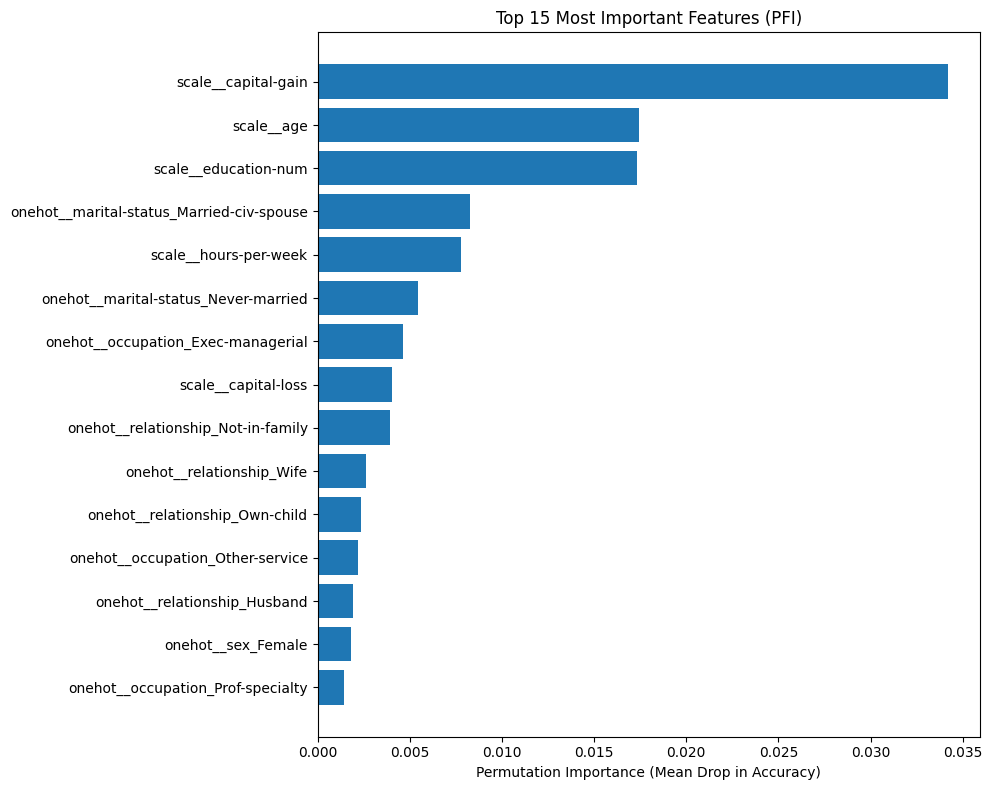

In [ ]:
full_feature_names = ct.get_feature_names_out()

X_test_dense = X_test_adult.toarray().astype(np.float32)

pfi_results = permutation_importance(
    model,
    X_test_dense,
    y_test_adult,
    n_repeats=10,
    random_state=42
    )

importances = pfi_results.importances_mean
sorted_indices = np.argsort(importances)
top_15_indices = sorted_indices[-15:]

print("\n--- Top 15 Most Important Features ---")
print("Feature\t\t\t | Importance (Drop in Accuracy)")
print("-" * 50)

for i in reversed(top_15_indices):
    feature_name = full_feature_names[i]
    score = importances[i]
    print(f"{feature_name:<30} | {score:.4f}")

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(
    np.array(full_feature_names)[top_15_indices],
    importances[top_15_indices]
)
ax.set_xlabel("Permutation Importance (Mean Drop in Accuracy)")
ax.set_title("Top 15 Most Important Features (PFI)")
plt.tight_layout()
plt.show()

Feature		 | Importance (Drop in R-squared)
----------------------------------------
Population	 | 0.0136
AveBedrms 	 | 0.0422
HouseAge  	 | 0.0713
AveRooms  	 | 0.0761
AveOccup  	 | 0.2107
MedInc    	 | 0.5770
Longitude 	 | 0.6211
Latitude  	 | 0.6637


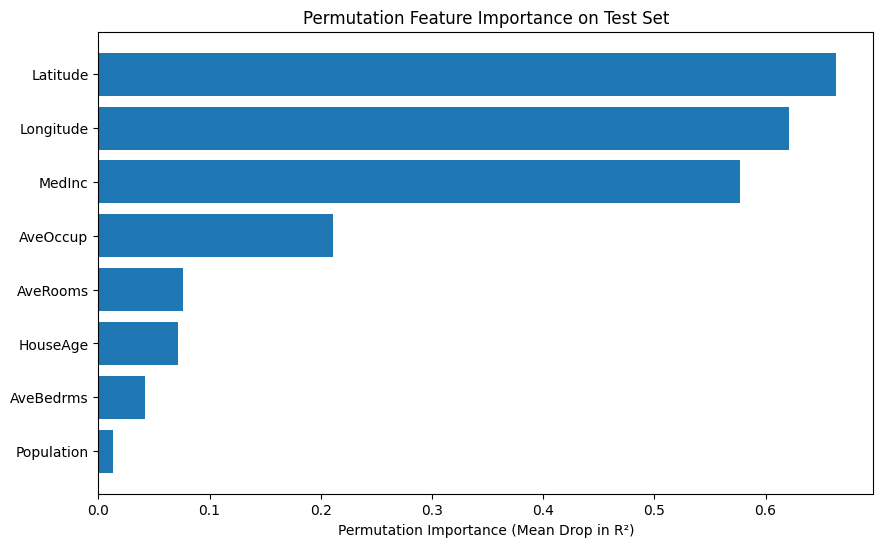

In [ ]:
# California Housing Dataset

original_feature_names = housing.feature_names

pfi_results = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
)

sorted_indices = pfi_results.importances_mean.argsort()

print("Feature\t\t | Importance (Drop in R-squared)")
print("-" * 40)
for i in sorted_indices:
    print(f"{original_feature_names[i]:<10}\t | {pfi_results.importances_mean[i]:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    np.array(original_feature_names)[sorted_indices],
    pfi_results.importances_mean[sorted_indices]
)
ax.set_xlabel("Permutation Importance (Mean Drop in R²)")
ax.set_title("Permutation Feature Importance on Test Set")
plt.show()

### b. Explain what the term “important” means when using the PFI method. 

When using the PFI method, the term "important" means how much the model's performance and its accuracy depend on a specific feature.
It is measured by looking at how much the model's prediction error increases when the data for that certain feature is randomly shuffled.

## 3. Accumulated Local Effects (ALE) (9 marks) 
### a. Implement ALE plots to investigate the local effects of feature changes. 

PyALE._ALE_generic:INFO: Discrete feature detected.


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


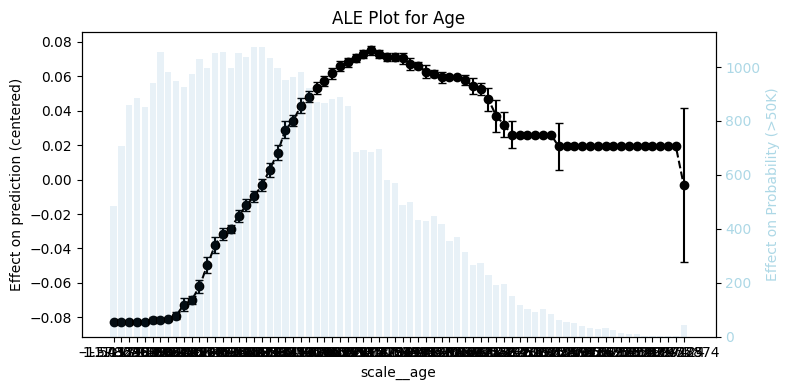

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


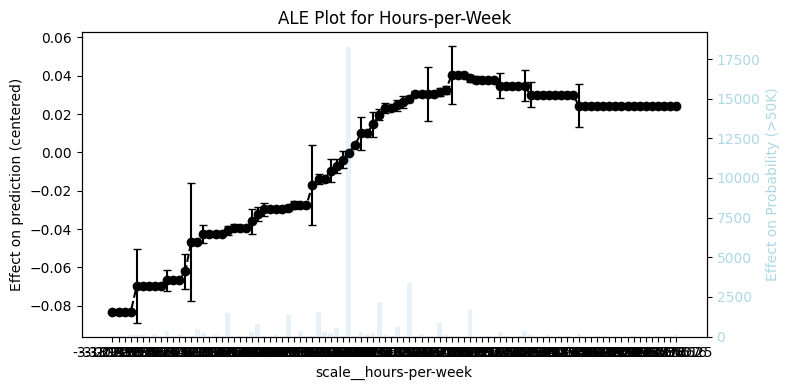

In [ ]:
full_feature_names = ct.get_feature_names_out()

X_train_scaled_df = pd.DataFrame(
    X_train_adult.toarray(), 
    columns=full_feature_names
).astype(np.float32)

ale_plot_age = ale(
    X=X_train_scaled_df,
    model=model,
    feature=["scale__age"],
    plot=True
)
plt.title("ALE Plot for Age")
plt.ylabel("Effect on Probability (>50K)")
plt.show()

ale_plot_hours = ale(
    X=X_train_scaled_df,
    model=model,
    feature=["scale__hours-per-week"],
    plot=True,
    feature_type='discrete'
)
plt.title("ALE Plot for Hours-per-Week")
plt.ylabel("Effect on Probability (>50K)")
plt.show()

PyALE._ALE_generic:INFO: Continuous feature detected.


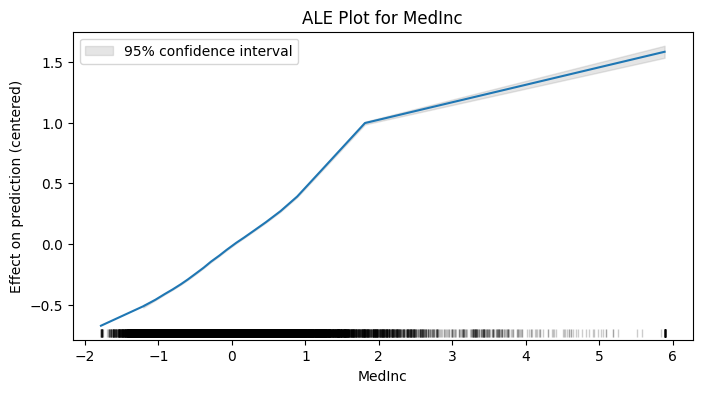

PyALE._ALE_generic:INFO: Continuous feature detected.


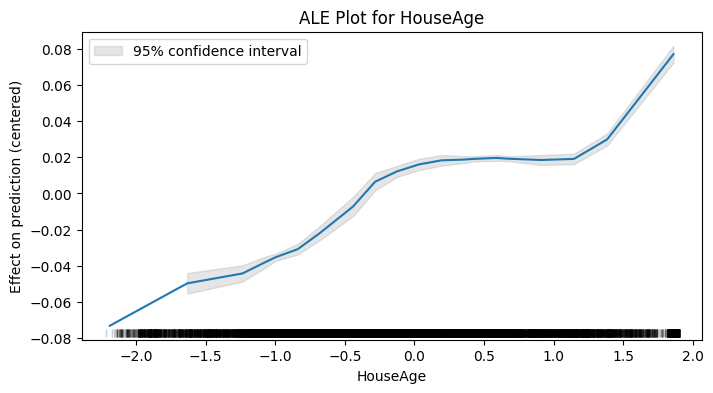

In [ ]:
# California Housing Dataset

original_feature_names = housing.feature_names

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)

ale_plot_medinc = ale(
    X=X_train_scaled_df,
    model=model,
    feature=["MedInc"],
    plot=True
)
plt.title("ALE Plot for MedInc")
plt.show()

ale_plot_houseage = ale(
    X=X_train_scaled_df,
    model=model,
    feature=["HouseAge"],
    plot=True
)
plt.title("ALE Plot for HouseAge")
plt.show()

### b. Compare ALE with PDP and discuss any differences in the interpretability of these techniques.

Adult Census

PDP calculates the average effect by forcing every data point to have a specific feature value, even if this creates unrealistic combinations, like pairing a "Doctorate" education with a "Farming" occupation. This can disrupt the plot showing a misleading average. 

ALE is a more robust technique as it avoids this, calculating the average of changes in predictions across local, realistic data windows, therefore limiting the feature's true effect. 

For this model, the most important insight is that the PDP and the ALE plots are almost identical. Both clearly show the same shape of the graph for age. It means the correlations were not strong enough to mislead the PDP giving us very high confidance that this is the true, isolated behavior the neural network learned.

California Housing

PDP seems to be simpler, e.g., to see the effect of MedInc, it takes a single value and forces all the house samples in the dataset to have this value, while keeping other features the same. Concequently, thiss might create unrealistic data, like a house with rural location, low income area, and have a MedInc as rich. While ALE acts smarter and safer, avoiding creating unreal data scenarios. It divides the feature into small parts and only looks at real houses in that specific part. It calculates the change in prediction just for those houses and then adds up these local changes across the whole feature.

However, in our case the graphs show similarity in both PDP and ALE. PDP for MedInc shows a steep rise and then plateauing the same as ALE, and even for HouseAge PDP illustrates a dip followed by a steep rise, exactly the same as ALE. Which signifies that even though PDP might be misleading, in this situation, the relationship between MedInc, HouseAge, and other features is not strong enough to significantly influence PDP.

## 4. Global Surrogates (7 marks) 
### a. Build an interpretable model to approximate the predictions of the feed-forward neural network model. 

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Surrogate Model Effectiveness ---
R-squared (Fidelity): 0.8045


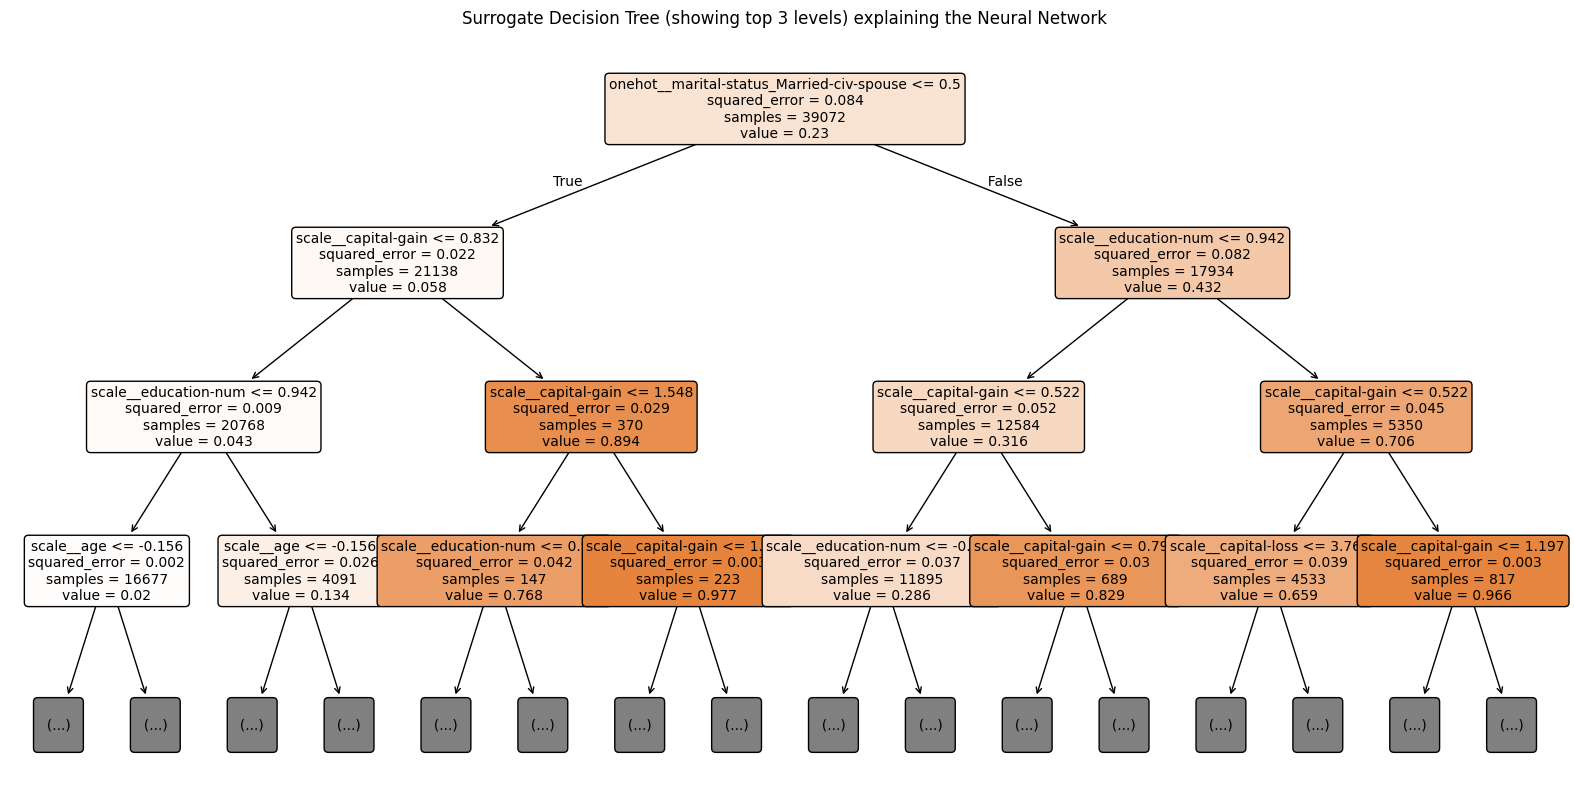

In [ ]:
full_feature_names = ct.get_feature_names_out()

X_train_dense_f32 = X_train_adult.toarray().astype(np.float32)
X_test_dense_f32 = X_test_adult.toarray().astype(np.float32)

nn_probs_train = model.predict_proba(X_train_dense_f32)[:, 1]

surrogate_model = DecisionTreeRegressor(max_depth=4, random_state=42)
surrogate_model.fit(X_train_dense_f32, nn_probs_train)

nn_probs_test = model.predict_proba(X_test_dense_f32)[:, 1]
surrogate_preds_test = surrogate_model.predict(X_test_dense_f32)

fidelity_r2 = r2_score(nn_probs_test, surrogate_preds_test)

print("\n--- Surrogate Model Effectiveness ---")
print(f"R-squared (Fidelity): {fidelity_r2:.4f}")

plt.figure(figsize=(20, 10))
plot_tree(
    surrogate_model,
    feature_names=full_feature_names,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Surrogate Decision Tree (showing top 3 levels) explaining the Neural Network")
plt.show()

R-squared (Fidelity): 0.6989


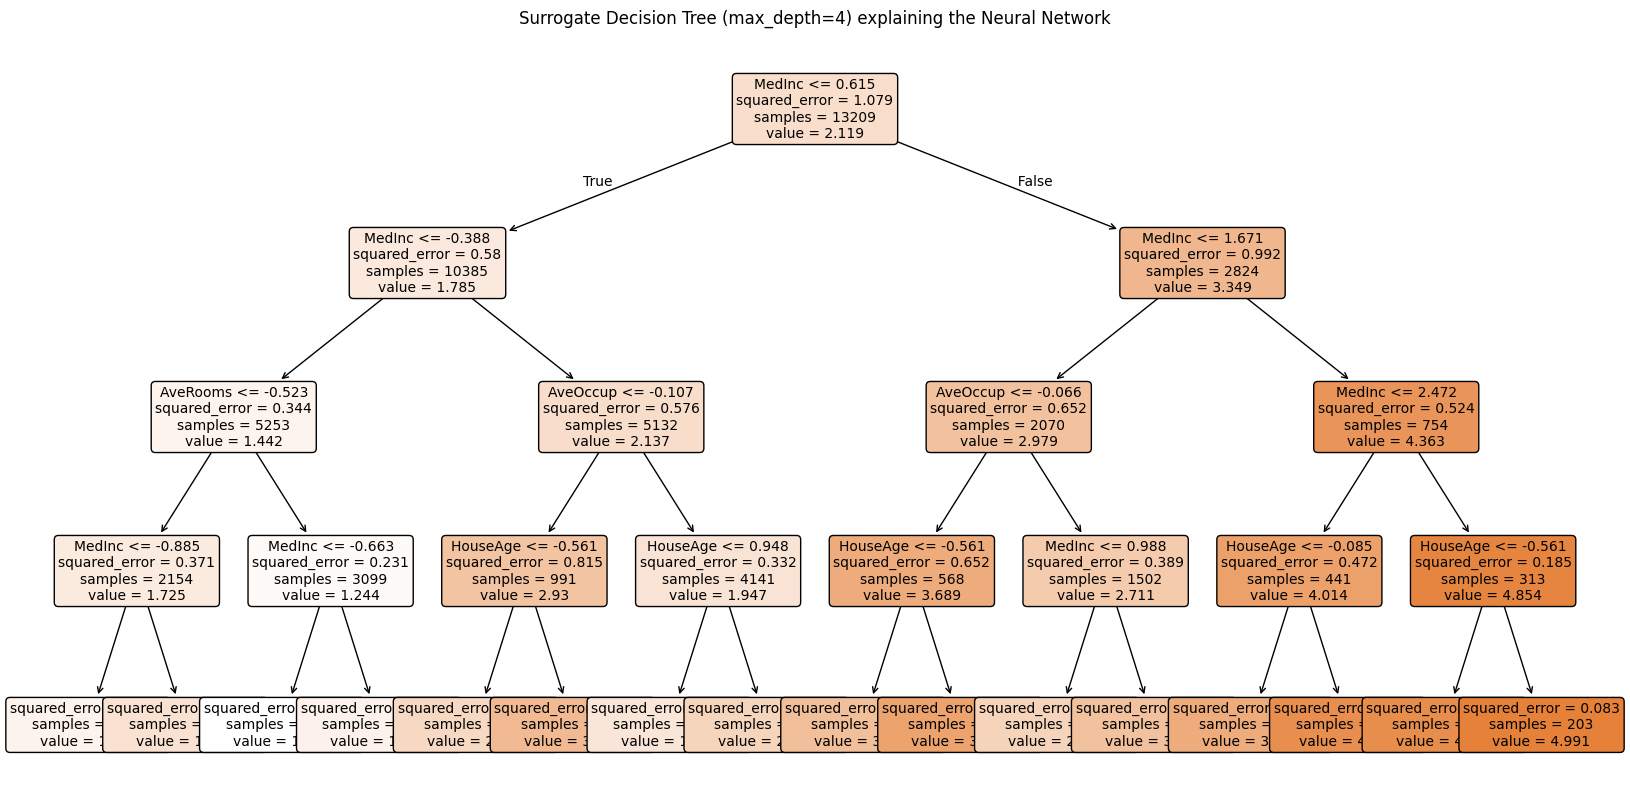

In [ ]:
# California Housing Dataset

nn_predictions_train = model.predict(X_train_scaled)

surrogate_model = DecisionTreeRegressor(max_depth=4, random_state=42)

surrogate_model.fit(X_train_scaled, nn_predictions_train)

nn_predictions_test = model.predict(X_test_scaled)
surrogate_predictions_test = surrogate_model.predict(X_test_scaled)

fidelity_r2 = r2_score(nn_predictions_test, surrogate_predictions_test)

print(f"R-squared (Fidelity): {fidelity_r2:.4f}")

original_feature_names = housing.feature_names
plt.figure(figsize=(20, 10))
plot_tree(
    surrogate_model,
    feature_names=original_feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Surrogate Decision Tree (max_depth=4) explaining the Neural Network")
plt.show()

### b. Analyse the surrogate model's effectiveness and discuss when such approximations are helpful.

Adult Census Income

The R-squared of 0.8045 is a high score indicating that our simple surrogate tree is a very effective approximation that successfully explains 80.45% of the neural network's complex logic. In practice such approximations are extremely helpful for translating a black-box model, just like our NNs, into a simple, readable set of rules, which is essential for understanding the logic. In this specific case, the surrogate is highly valuable because it proves our NN's logic is sensible. It learned that the single most important predictor is onehot__marital-status_Married-civ-spouse, followed by logical features like scale__capital-gain and scale__education-num, giving us a good summary of the model.

California Housing

The Global Surrogate model's R-squared score of 0.6848 indicates a moderate fidelity. A simple, 4-level deep desicion tree was chosen as a surrogate model, which managed to explain 68.5% of the neural network's logic. This decent score shows that the neural network has learned quite a complex and non-linear set of rules that cannot be perfectly captured in a simple and interpretable model. Generally, the use of Global Surrogate models can be very helpful when we need to explain a black box model such as various neural networks and other architectures. Which makes the model be more understandable and easy to interpret.

# Part 2: Local Interpretability Techniques (30 marks)  
You will use the Adult Census Income dataset in this part. You should use the feed-forward 
neural network you trained in Part 1 and apply the following interpretability techniques: 

## 1. Local Interpretable Model-agnostic Explanations (LIME) (10 marks) 
### a. Apply LIME to explain individual predictions from the feed-forward neural network model. 

 


In [ ]:
explainer = LimeTabularExplainer(
    training_data=X_train_adult,
    feature_names=output_feature_names,
    class_names=['<=50K', '>50K'],
    categorical_features=[],
    mode='classification'
)

def lime_predict_fn(x):
    probs = model_adult.model_.predict(x)
    return np.column_stack([1 - probs, probs])

# sample id 5 for >50k, sample id 1 for <=50k
sample_id = 1
sample_to_explain = X_test_adult[sample_id]
exp = explainer.explain_instance(
    data_row=sample_to_explain,
    predict_fn=lime_predict_fn,
    num_features=10
)
exp.show_in_notebook(show_table=True, show_all=False)

sample_id = 5
sample_to_explain = X_test_adult[sample_id]
exp = explainer.explain_instance(
    data_row=sample_to_explain,
    predict_fn=lime_predict_fn,
    num_features=10
)
exp.show_in_notebook(show_table=True, show_all=False)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### b. Explain how LIME approximates the local decision boundary and what the interpretation suggests. 

LIME approximates the local decision boundary by generating synthetic samples around the data point being explained, querying the trained model for predictions on these samples, and then fitting a simple interpretable model (such as a linear model) weighted heavily by proximity to the original point. This surrogate model captures the complex model’s behavior in the immediate neighborhood, indicating which features contributed most to the prediction for that specific case. 

In practice, this means LIME shows which variables such as: scaled capital gain, capital loss, country, and workclass—most strongly influenced the neural network’s decision for the selected individual, visualized through colored bars that reflect positive or negative impact on the predicted class. These explanations are faithful locally but do not generalize to the global decision surface.


## 2. Shapley Additive Explanations (SHAP) (10 marks) 
### a. Use SHAP values to explain model predictions. 

 


In [ ]:
# Your model prediction function returns probability for >50K
# model.model_.predict(x) needs X of shape (n, 108)
def shap_predict(x):
    return model_adult.model_.predict(x)

# Choose 100 random rows from train for background (shape: (100, 108))
background = X_train_adult[np.random.choice(X_train_adult.shape[0], 100, replace=False)]

# KernelExplainer expects a function and background samples
explainer = shap.KernelExplainer(shap_predict, background)

# Calculate SHAP values for one sample
sample_to_explain = X_test_adult[0:1]  # keep it 2D
shap_values = explainer.shap_values(sample_to_explain)

print('Shape of sample:', sample_to_explain.shape)
print('Shape of shap_values[0]:', shap_values[0].shape)  # For binary classification
print('Length of feature_names:', len(output_feature_names))

def fix_shape(shap_vals, sample):
    # If shape is (features, 1), flatten to (features,)
    if shap_vals.ndim == 2 and shap_vals.shape[1] == 1:
        shap_vals = shap_vals.flatten()
    # If sample is still 2D: (1, features), flatten to (features,)
    if sample.ndim == 2 and sample.shape[0] == 1:
        sample = sample.flatten()
    return shap_vals, sample

# Apply to your values
good_shap_values, good_sample = fix_shape(shap_values[0], sample_to_explain)

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    good_shap_values,
    good_sample,
    feature_names=output_feature_names
)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
6819/6819 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


100%|██████████| 1/1 [00:16<00:00, 16.85s/it]


Shape of sample: (1, 108)
Shape of shap_values[0]: (108, 1)
Length of feature_names: 108


### b. Compare SHAP explanations with LIME and discuss any differences between the two. 

SHAP and LIME both explain how features contribute to individual predictions, but they use different approaches and display different information about the data. LIME fits a simple local model around the point being explained, highlighting which variables most influenced the prediction for that particular case. Its strength is quick, localized interpretability, but explanations can vary based what sample is chosen, which can lead to instability.

SHAP, on the other hand, uses Shapley values to fairly distribute credit among features by considering all possible feature combinations. This results in more consistent attributions, which sum to the model's output over the base value. SHAP also provides both local and global perspectives and is more stable, but it can be computationally intensive. Therefore,  Lime is used for quick local explanations and SHAP is used when you need consistent data on the interpretation of local models.



## 3. Anchors (10 marks) 
### a. Implement Anchors to interpret model predictions for specific cases. 


In [ ]:


X_train_anchor = X_train_raw.copy()
X_test_anchor = X_test_raw.copy()


categorical_names = {}
for col in cat_cols:
    codes_train, uniques = pd.factorize(X_train_anchor[col])
    X_train_anchor[col] = codes_train
    mapping = {cat: i for i, cat in enumerate(uniques)}
    codes_test = X_test_anchor[col].map(mapping).fillna(-1).astype(int)
    X_test_anchor[col] = codes_test  # unknowns as -1
    categorical_names[X_train_anchor.columns.get_loc(col)] = list(uniques)

def anchor_predict(x):
    # x: 2D numpy array, integer codes for categorical, floats for numerics
    df = pd.DataFrame(x, columns=X_train_anchor.columns)
    for col in cat_cols:
        # Map int codes back to original strings
        idx = X_train_anchor.columns.get_loc(col)
        mapping = dict(enumerate(categorical_names[idx]))
        df[col] = df[col].map(mapping)
    # Now all categorical columns restored to string form
    X_proc = ct.transform(df)
    preds = (model_adult.model_.predict(X_proc) > 0.5).astype(int).flatten()
    return preds



explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=['<=50K', '>50K'],
    feature_names=X_train_anchor.columns.tolist(),
    train_data=X_train_anchor.values,
    categorical_names=categorical_names
)

sample_id = 1  # or another ID for >50K
data_instance = X_test_anchor.values[sample_id]
exp = explainer.explain_instance(data_instance, anchor_predict, threshold=0.95)

print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

#
#
# WRITE THIS IN THE GEN AI USAGE SEGMENT 
# -> exp.show_in_notebook() was not working, therefore asked Perplexity to help me work around it
from IPython.display import display, HTML 
display(HTML(exp.as_html()))




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━

ValueError: invalid literal for int() with base 10: 'Other-service'

### b. Compare Anchors with LIME and SHAP, and discuss any differences between them. 

Anchors provide high-precision explanations by explaining rule-based conditions (like "occupation = Other-service" and "education-num <= 12") that confidently predict a model’s output. They give if-then style explanations which are easy to understand as they show a small set of conditions that almost always guarantee a specific prediction. This makes anchors very good at providing strong, focused explanations that apply to specific regions of the data.

In contrast, LIME and SHAP explain predictions by estimating the contribution of each feature to an individual prediction. LIME works by approximating the model locally with a simple interpretable model. SHAP explains predictions by assigning feature importance values to each feature based on game theory, showing how much each feature pushes the prediction toward a class. These methods give a more refined understanding but can be less intuitive because they do not directly produce clear rules or anchors.

In summary, anchors focus on simple, precise rule conditions providing clarity on when the model predicts a certain class. LIME and SHAP provide detailed feature contributions explaining why the model made a specific prediction without necessarily giving a direct rule to follow. 


# Part 3: Example-Based Explanations (20 marks)  
You will use the Adult Census Income dataset in this part. You should use the feed-forward 
neural network you trained in Part 1 and apply the following interpretability techniques: 
## 1. Counterfactual Explanations (10 marks) 
### a. Generate counterfactuals for at least two incorrect predictions. 

In [7]:
import dice_ml
X_test_df = pd.DataFrame(
    X_test_adult.astype(np.float32), 
    columns=output_feature_names
)
dataset_for_dice = X_test_df.copy()
dataset_for_dice["income"] = y_test_raw.values

continuous_features = [col for col in output_feature_names if col.startswith("scale__")]

d = dice_ml.Data(
    dataframe=dataset_for_dice,
    continuous_features=continuous_features,
    outcome_name="income"
)

m = dice_ml.Model(model=model_adult, backend="sklearn")

exp = dice_ml.Dice(d, m, method="random")

y_pred = model_adult.predict(X_test_adult)

incorrect_indices = np.where(y_pred != y_test_raw.values)[0]

print(f"Found {len(incorrect_indices)} incorrect predictions.")

selected_indices = incorrect_indices[:2]

for i, idx in enumerate(selected_indices):
    print(f"=== Case {i+1}: Test Index {idx} ===")
    
    # Get the query instance (the person's data) as a DataFrame
    query_instance = X_test_df.iloc[[idx]]
    
    actual_label = y_test_raw.values[idx]
    predicted_label = y_pred[idx]
    
    print(f"Actual Income: {'>50K' if actual_label==1 else '<=50K'}")
    print(f"Model Predicted: {'>50K' if predicted_label==1 else '<=50K'} (Incorrect)")
    print("Generating counterfactuals to flip this prediction...\n")
    
    dice_exp = exp.generate_counterfactuals(
        query_instance, 
        total_CFs=3, 
        desired_class="opposite",
        features_to_vary=continuous_features 
        )
        
        # Visualize the result (showing only what changed)
    dice_exp.visualize_as_dataframe(show_only_changes=True)
    print("\n" + "-"*50 + "\n")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Found 1359 incorrect predictions.
=== Case 1: Test Index 16 ===
Actual Income: >50K
Model Predicted: <=50K (Incorrect)
Generating counterfactuals to flip this prediction...



  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\InterpretableAI_ARI3205\.venv\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.88311173' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\InterpretableAI_ARI3205\.venv\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.0734413' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
c:\UoM\Year 3\ARI3205 Interpretable AI for DL 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

Query instance (original outcome : 1)


onehot__workclass_?  onehot__workclass_Federal-gov  \
0                  0.0                            0.0   

   onehot__workclass_Local-gov  onehot__workclass_Never-worked  \
0                          0.0                             0.0   

   onehot__workclass_Private  onehot__workclass_Self-emp-inc  \
0                        1.0                             0.0   

   onehot__workclass_Self-emp-not-inc  onehot__workclass_State-gov  \
0                                 0.0                          0.0   

   onehot__workclass_Without-pay  onehot__education_10th  ...  \
0                            0.0                     0.0  ...   

   onehot__native-country_United-States  onehot__native-country_Vietnam  \
0                                   1.0                             0.0   

   onehot__native-country_Yugoslavia  scale__age  scale__fnlwgt  \
0                                0.0   -0.701573        0.14656   

   scale__education-num  scale__capital-gain  scale__capital-loss  \
0              -0.42008             -0.14515            -0.218923   

   scale__hours-per-week  income  
0              -0.032755       1  

[1 rows x 109 columns]


Diverse Counterfactual set (new outcome: 0)


onehot__workclass_? onehot__workclass_Federal-gov  \
0                   -                             -   
1                   -                             -   
2                   -                             -   

  onehot__workclass_Local-gov onehot__workclass_Never-worked  \
0                           -                              -   
1                           -                              -   
2                           -                              -   

  onehot__workclass_Private onehot__workclass_Self-emp-inc  \
0                         -                              -   
1                         -                              -   
2                         -                              -   

  onehot__workclass_Self-emp-not-inc onehot__workclass_State-gov  \
0                                  -                           -   
1                                  -                           -   
2                                  -                           -   

  onehot__workclass_Without-pay onehot__education_10th  ...  \
0                             -                      -  ...   
1                             -                      -  ...   
2                             -                      -  ...   

  onehot__native-country_United-States onehot__native-country_Vietnam  \
0                                    -                              -   
1                                    -                              -   
2                                    -                              -   

  onehot__native-country_Yugoslavia scale__age scale__fnlwgt  \
0                                 -          -             -   
1                                 -          -             -   
2                                 -          -             -   

  scale__education-num scale__capital-gain scale__capital-loss  \
0                    -                   -                   -   
1                    -                   -                   -   
2                    -                   -                   -   

  scale__hours-per-week income  
0    0.8462969660758972      -  
1    2.4597229957580566      -  
2     4.076894283294678      -  

[3 rows x 109 columns]


--------------------------------------------------

=== Case 2: Test Index 47 ===
Actual Income: >50K
Model Predicted: <=50K (Incorrect)
Generating counterfactuals to flip this prediction...



  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\InterpretableAI_ARI3205\.venv\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.804262448' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\InterpretableAI_ARI3205\.venv\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.30233463' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
c:\UoM\Year 3\ARI3205 Interpretable AI for D

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Query instance (original outcome : 1)


onehot__workclass_?  onehot__workclass_Federal-gov  \
0                  0.0                            0.0   

   onehot__workclass_Local-gov  onehot__workclass_Never-worked  \
0                          0.0                             0.0   

   onehot__workclass_Private  onehot__workclass_Self-emp-inc  \
0                        1.0                             0.0   

   onehot__workclass_Self-emp-not-inc  onehot__workclass_State-gov  \
0                                 0.0                          0.0   

   onehot__workclass_Without-pay  onehot__education_10th  ...  \
0                            0.0                     0.0  ...   

   onehot__native-country_United-States  onehot__native-country_Vietnam  \
0                                   1.0                             0.0   

   onehot__native-country_Yugoslavia  scale__age  scale__fnlwgt  \
0                                0.0    3.749942        0.07653   

   scale__education-num  scale__capital-gain  scale__capital-loss  \
0              -0.42008             -0.14515            -0.218923   

   scale__hours-per-week  income  
0              -0.032755       1  

[1 rows x 109 columns]


Diverse Counterfactual set (new outcome: 0)


onehot__workclass_? onehot__workclass_Federal-gov  \
0                   -                             -   
1                   -                             -   
2                   -                             -   

  onehot__workclass_Local-gov onehot__workclass_Never-worked  \
0                           -                              -   
1                           -                              -   
2                           -                              -   

  onehot__workclass_Private onehot__workclass_Self-emp-inc  \
0                         -                              -   
1                         -                              -   
2                         -                              -   

  onehot__workclass_Self-emp-not-inc onehot__workclass_State-gov  \
0                                  -                           -   
1                                  -                           -   
2                                  -                           -   

  onehot__workclass_Without-pay onehot__education_10th  ...  \
0                             -                      -  ...   
1                             -                      -  ...   
2                             -                      -  ...   

  onehot__native-country_United-States onehot__native-country_Vietnam  \
0                                    -                              -   
1                                    -                              -   
2                                    -                              -   

  onehot__native-country_Yugoslavia          scale__age scale__fnlwgt  \
0                                 -                   -             -   
1                                 -  2.8204822540283203             -   
2                                 -                   -             -   

  scale__education-num scale__capital-gain scale__capital-loss  \
0                    -                   -                   -   
1                    -                   -                   -   
2                    -                   -  0.4010750353336334   

  scale__hours-per-week income  
0     4.522335529327393      -  
1                     -      -  
2                     -      -  

[3 rows x 109 columns]


--------------------------------------------------



### b. Discuss the counterfactual’s importance for debugging models and decision-making.

## 2. Prototypes and Criticisms (10 marks) 
### a. Identify prototypes and criticisms from the dataset. 

### b. Discuss how prototypes and criticisms can be used within the context of interpretable AI. 